**Import Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import warnings
import seaborn as sns
import math
import shutil
import random
from keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D,Dropout,BatchNormalization,Reshape
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Set Dataset Paths**

In [ ]:
dataset_folder = "/content/drive/MyDrive/Fruit And Vegetable Diseases Dataset"  # Change this path

# Define training and validation directories
train_dir = os.path.join(dataset_folder, "train")
val_dir = os.path.join(dataset_folder, "validation")

**Data Preprocessing & Augmentation**

In [ ]:
# Image preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting data into train (80%) and validation (20%)
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load dataset
train_data = train_datagen.flow_from_directory(
    dataset_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = val_datagen.flow_from_directory(
    dataset_folder,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_data.class_indices)  # Count classes dynamically


Found 6189 images belonging to 28 classes.
Found 1539 images belonging to 28 classes.


**Training vs Validation Class Distribution**

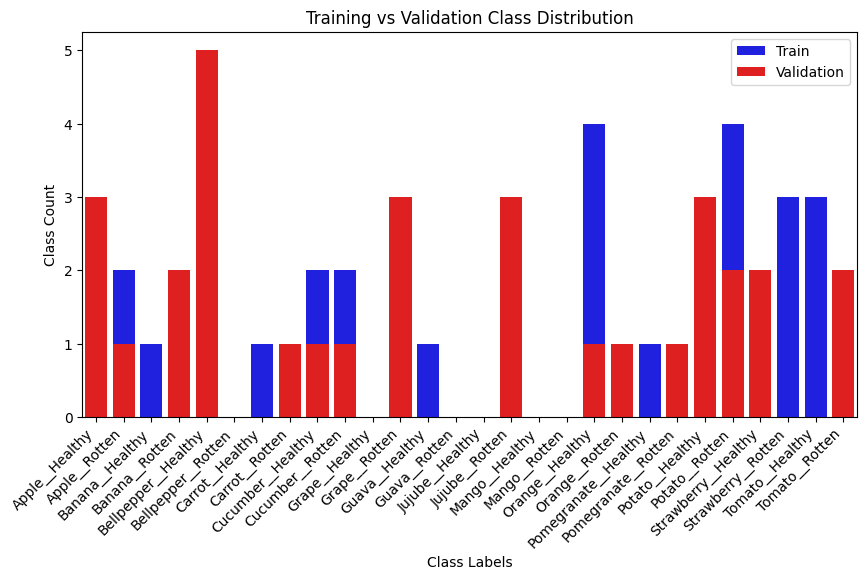

In [ ]:
# Get class labels from the dataset
class_labels = list(train_data.class_indices.keys())

# Initialize class counts
train_counts = {label: 0 for label in class_labels}
val_counts = {label: 0 for label in class_labels}

# Count images in the training dataset
for _, labels in train_data:
    for label in labels.argmax(axis=1):
        train_counts[class_labels[label]] += 1
    break  # Count only the first batch
# Count images in the validation dataset
for _, labels in val_data:
    for label in labels.argmax(axis=1):
        val_counts[class_labels[label]] += 1
    break
# Plot both training and validation counts
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), color="blue", label="Train")
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), color="red", label="Validation")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Class Labels")
plt.ylabel("Class Count")
plt.title("Training vs Validation Class Distribution")
plt.legend()
plt.show()


**Displays the image**

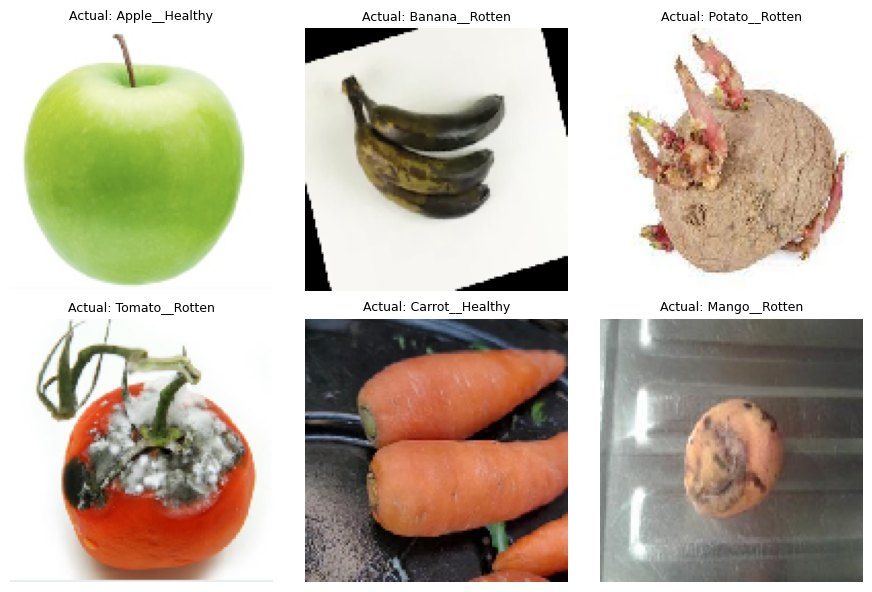

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Load a random batch of images from the validation dataset
batch_images, batch_labels = next(val_data)

# Get class labels
class_labels = list(train_data.class_indices.keys())

# Plot 6 random images from the batch
plt.figure(figsize=(9, 6))  # Smaller figure size

for i in range(6):
    random_index = random.randint(0, batch_images.shape[0] - 1)
    image = batch_images[random_index]
    true_label = np.argmax(batch_labels[random_index])
    actual_class = class_labels[true_label]

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Actual: {actual_class}", fontsize=9)  # Smaller font size

plt.tight_layout()
plt.show()

**Define CNN Model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),  # Added Layer
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Increased neurons
    layers.Dropout(0.6),  # Increased dropout to reduce overfitting
    layers.Dense(num_classes, activation='softmax')  # Output Layer
])
# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Display Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,592,092 (17.52 MB)

 Trainable params: 4,591,132 (17.51 MB)

 Non-trainable params: 960 (3.75 KB)

**Data Training**

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=150, batch_size=32)

Epoch 1/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 116s 600ms/step - accuracy: 0.1990 - loss: 2.7205 - val_accuracy: 0.2820 - val_loss: 2.3384
Epoch 2/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 115s 593ms/step - accuracy: 0.1994 - loss: 2.6538 - val_accuracy: 0.3158 - val_loss: 2.3779
Epoch 3/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 118s 610ms/step - accuracy: 0.2143 - loss: 2.6060 - val_accuracy: 0.3223 - val_loss: 2.3523
Epoch 4/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 116s 599ms/step - accuracy: 0.2338 - loss: 2.5576 - val_accuracy: 0.3086 - val_loss: 2.2778
Epoch 5/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 115s 596ms/step - accuracy: 0.2360 - loss: 2.5197 - val_accuracy: 0.3912 - val_loss: 2.0487
Epoch 6/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 117s 604ms/step - accuracy: 0.2523 - loss: 2.4637 - val_accuracy: 0.3587 - val_loss: 2.0616
Epoch 7/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 114s 589ms/step - accuracy: 0.2508 - loss: 2.4622 - val_accuracy: 0.3411 - val_loss: 2.1520
Epoch 8/150
194/194 ━━━━━━━━━━━━━━━━━━━━ 116s 599ms/step - accuracy: 

**Evaluate on validation set**

In [ ]:
import matplotlib.pyplot as plt

# Evaluate on validation set
test_loss, test_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {test_acc:.2f}")
print(f"Validation Loss: {test_loss:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.8975 - loss: 0.5033
Validation Accuracy: 0.89
Validation Loss: 0.5175


**Plot Accuracy & Loss Graph**

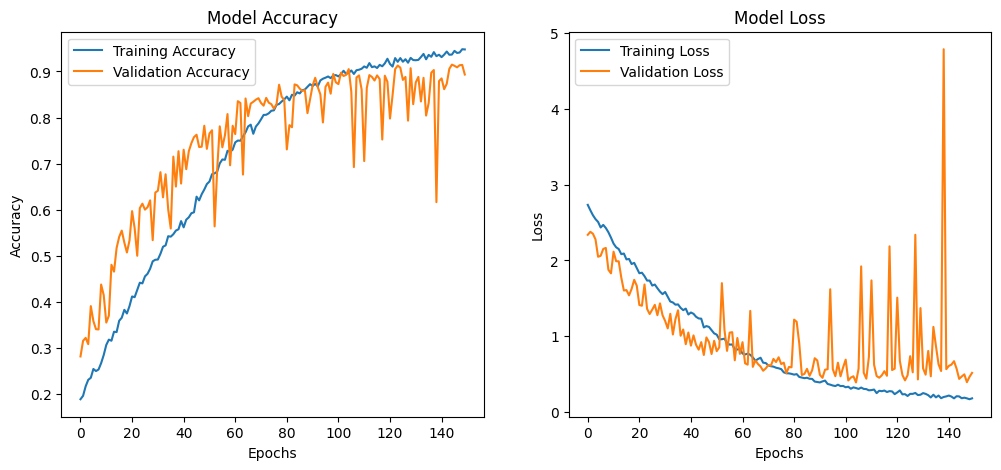

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

# Call function after training
plot_history(history)


**Predicted Class and Accuracy (confidence score)**

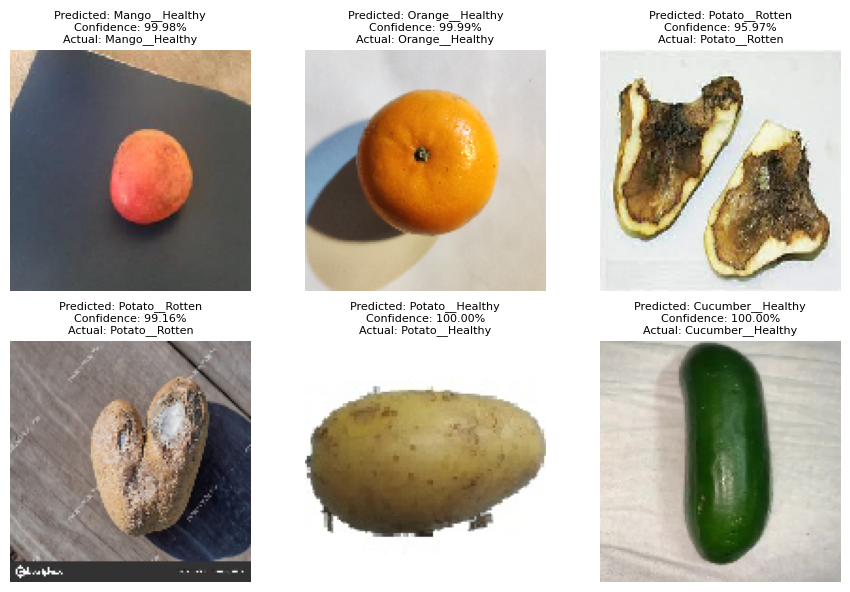

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get a random batch of images and labels from the validation set
batch_images, batch_labels = next(val_data)

# Get class names from the dataset
class_labels = list(train_data.class_indices.keys())

# Plot 6 random images with predictions
plt.figure(figsize=(9, 6))  # Smaller display size

for i in range(6):
    random_index = random.randint(0, batch_images.shape[0] - 1)
    image = batch_images[random_index]
    true_label_index = np.argmax(batch_labels[random_index])
    true_class = class_labels[true_label_index]

    # Predict using CNN model
    prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_index]
    confidence = np.max(prediction) * 100

    # Plot image and prediction info
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Predicted: {predicted_class}\n"
        f"Confidence: {confidence:.2f}%\n"
        f"Actual: {true_class}",
        fontsize=8
    )

plt.tight_layout()
plt.show()


**Save the Trained Model**

In [ ]:
import keras.saving
keras.saving.save_model(model, "fruit_veg_classifier.keras")